# Recognizing handwritten numbers with DL

In this session you will be taken trhough the process of training DL models (MLP & CNN) to predict handwritten numbers.

To this end, we will undergo the following steps:

* Import packages
* Define, download & preprocess the dataset
* Take a look at the data
* Understand how a NN is trained in practice
* Create an MLP, train it and evaluate it.
* Create a CNN, train it and evaluate it. 
* Compare the models

Let's get to it!

**Important!** If you have questions trhough the tutorial, ask me! :) 

**Question:** How acquainted are you with Object Oriented Programming?

### 1. Import packages (and check if they are working)

In [86]:
import torch # pytorch
import torchvision # utilities for Computer vision datasets
import matplotlib.pyplot as plt # Utilities for plotting 
import numpy as np # package for numerical operations
import copy # Package to deepcopy data structures
import time # Package to measure time

# other utilities for faster typing
import torch.nn as nn
from torchvision import transforms
from torch.utils.data import random_split, DataLoader

In [4]:
# If you installed torch with cuda support AND you have a GPU, then this should output true
# Not a problem if you don't have a GPU.
torch.cuda.is_available()

True

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

### 2. Define and download the dataset

In this tutorial we will work with MNIST: a popular dataset of hendwritten digits ( http://yann.lecun.com/exdb/mnist/ ). Luckily, using standard datasets is very easy with PyTorch. Most of them are already implemented.

In [10]:
# First we define the transformations that will be applied to our data
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Normalize by mean & std of train dataset.
    ]
)
# Then, we pass them as an argument to our dataset generator.
# The dataset will be downloaded in ./data
mnist = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True,
)
# We need to split the data into training and validation
train_dataset, val_dataset = random_split(mnist, [55000, 5000])
# We also download the test set (to be used only for testing)!
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True,
)

That's it! The data has been downloaded and preprocessed.

The next step is to create a DataLoader. This is a utility that iterates trhough the dataset.

In [88]:
batch_size = 100 # The number of data samples that will go each step through the network.

train_dataloader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True, # IMPORTANT! Shuffle the data s.t. the net does not see the same batches always during training.
)
val_dataloader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
)
test_dataloader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

Let's take a look at the data:

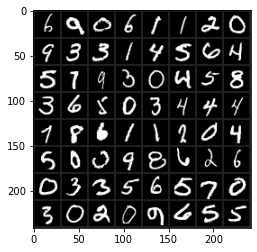

In [26]:
def imshow(img):
    img = img * 0.3081 + 0.1307     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()
    
# get some random training images
dataiter = iter(train_dataloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images))
# What we see is a single batch. 
# If you rerun this cell you will see different samples. Why?

**important** The data has structure `[batch_size, no_channels, Y, X]`

**Question:** What is the structure of the images passed to `make_grid`?

### 3. Understanding how a network is trained

Now, we will define a training / test loop and understand what is the logic of each step.

In [81]:
def training_loop(
    epochs: int,
    model: torch.nn.Module,
    criterion: torch.nn.Module,
    optimizer: torch.optim.Optimizer,
    dataloaders: dict[str, DataLoader],
    device: str,
):
    # Send model to device where training happens
    model.to(device)
    
    # Save the best weights - We need to save the best weights for the test set.
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    
    # We save the results per epoch for train and val for subsequent analysis
    accuracies = {
        'train': [],
        'val':[],
    }
    losses = {
        'train': [],
        'val':[],
    }
    
    # We iterate no_epochs epochs trhough the entire training data
    for epoch in range(epochs):
        print(f"Epoch {epoch + 1} / {epochs}")
        
        # Let's measure the time per epoch
        epoch_start_time = time.time()
        
        # Per epoch there are two phases: training and validation
        for phase in ["train", "val"]:
            
            # Accumulate accuracy and loss for the epoch
            running_loss = 0
            running_corrects = 0
            total = 0
            
            # Networks have two execution types: training (with gradient accum.) and eval (without)
            if phase == "train":
                model.train()
            else:
                model.eval()
                
            # Now we iterate trhough the data of each dataset (train / val)
            for batch in dataloaders[phase]:
                # each batch has inputs (the image) and labels (the label of each image)
                inputs, labels = batch
                # We then send the data to the device in which the training happens.
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                # First we clean the gradients of each network parameter
                optimizer.zero_grad()
                
                # If we are in training, we enable gradient calculation
                with torch.set_grad_enabled(phase == 'train'):
                    
                    # Next, we pass the data through the input, calculate the predictions and the loss.
                    # Remember that the loss is what we use to train the network. It needs to be differentiable.
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        # With this, we now perform the backward pass:
                        # 1. calculate the gradients of the loss wrt each parameter
                        loss.backward()
                        # 2. use the optimizer to update the weights
                        optimizer.step()
            
                # Statistics for the epoch
                running_loss += loss.item() * inputs.size(0)
                running_corrects += (preds == labels).sum().item()
                total += labels.size(0)
            
            # statistics of the epoch
            epoch_loss = running_loss / total
            epoch_acc = running_corrects / total
            print(f'{phase} loss: {epoch_loss:.4f}, accuracy: {epoch_acc:.4f}')
            # append results to dictionaries
            accuracies[phase].append(epoch_acc)
            losses[phase].append(epoch_loss)
            
            # To finish, we need also to check the accuracy so far and update the best val weights.
            if phase == "val" and epoch_acc >= best_acc:
                # Update best acc
                best_acc = epoch_loss
                # Update weights (The state_dict contains a dict with names / vaues of the parameters).
                best_model_wts = copy.deepcopy(model.state_dict())
                
        # Let measure the time at the end of the epoch
        epoch_end_time = time.time()
        phase_time = epoch_end_time - epoch_start_time
        print(f'Time per epoch: {phase_time:.4f}')
                
    # Report best results
    print(f"Best validation accuracy: {best_acc:.4f}")
    # Load best model weights 
    model.load_state_dict(best_model_wts)
    
    return model, accuracies, losses 


def test_loop(
    model: torch.nn.Module,
    test_dataloader: DataLoader,
    device: str,
):
    # Send model to device where test happens
    model.to(device)
    
    # Set model to evaluation mode
    model.eval()
    
    # Summarize results
    correct = 0
    total = 0
    
    # Tell pytorch not to keep track of gradients
    with torch.no_grad():
        
        for batch in test_dataloader:    
            # each batch has inputs (the image) and labels (the label of each image)
            inputs, labels = batch
            # We then send the data to the device in which the training happens.
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    # Print results
    test_acc = correct / total
    print(f'Accuracy of the network on the {total} test samples: {100 * test_acc:.2f}')

Now we have an idea of how a network is actually implemented in practice. 
We can now define our network.

### 4. Create a MLP

First we create a MLP. The idea will be to have in both cases a network with 4 hidden layers.

In [89]:
class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=28*28, out_features=10*28*28)
        self.layer2 = nn.Linear(in_features=10*28*28, out_features=10*14*14)
        self.layer3 = nn.Linear(in_features=10*14*14, out_features=10*7*7)
        self.layer4 = nn.Linear(in_features=10*7*7, out_features=10*4*4)
        self.out_layer = nn.Linear(in_features=10*4*4, out_features=10)

    def forward(self, x):
        # Linear layer expects shape [batch, no_channels]
        batch_size = x.shape[0]
        x = x.view(batch_size, -1)
        out = torch.relu(self.layer1(x))
        out = torch.relu(self.layer2(out))
        out = torch.relu(self.layer3(out))
        out = torch.relu(self.layer4(out))
        out = self.out_layer(out)
        return out

mlp = MLP()

In [90]:
# How big is the network?
def num_params(model: torch.nn.Module):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The MLP has {num_params(mlp)} learnable parameters')

The MLP has 22563820 learnable parameters


Now, let's train our network. But before, we need to specify our criterion and our optimizer.

In [91]:
# Optimizer
lr = 0.001 # The learning rate of the optimizer
weight_decay = 1e-5 # Regularization on the size of the weights
optimizer = torch.optim.Adam( # Best optimizer out there. Named after Amsterdam.
    mlp.parameters(), 
    lr=lr,
    weight_decay=weight_decay,
)

# Optimization criterion: Cross entropy loss. The to-go loss for classifcation tasks.
# See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss() 

In [92]:
# Let's train the MLP for 10 epochs
# IMPORTANT!: Difficult tasks often require (much) more epochs.
no_epochs = 10
_, mlp_accuracies, mlp_losses = training_loop(
    epochs=no_epochs,
    model=mlp,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders={
        'train': train_dataloader,
        'val': val_dataloader,
    },
    device=device,
)

Epoch 1 / 10
train loss: 0.2315, accuracy: 0.9293
val loss: 0.1698, accuracy: 0.9490
Time per epoch: 34.1373
Epoch 2 / 10
train loss: 0.1077, accuracy: 0.9687
val loss: 0.1289, accuracy: 0.9630
Time per epoch: 47.5769
Epoch 3 / 10
train loss: 0.0778, accuracy: 0.9777
val loss: 0.1162, accuracy: 0.9660
Time per epoch: 43.3927
Epoch 4 / 10
train loss: 0.0624, accuracy: 0.9820
val loss: 0.0986, accuracy: 0.9748
Time per epoch: 41.8385
Epoch 5 / 10
train loss: 0.0563, accuracy: 0.9837
val loss: 0.0792, accuracy: 0.9792
Time per epoch: 58.7516
Epoch 6 / 10
train loss: 0.0401, accuracy: 0.9881
val loss: 0.0945, accuracy: 0.9750
Time per epoch: 53.7523
Epoch 7 / 10
train loss: 0.0403, accuracy: 0.9880
val loss: 0.0905, accuracy: 0.9776
Time per epoch: 55.9276
Epoch 8 / 10
train loss: 0.0350, accuracy: 0.9894
val loss: 0.0878, accuracy: 0.9782
Time per epoch: 45.8773
Epoch 9 / 10
train loss: 0.0339, accuracy: 0.9899
val loss: 0.1005, accuracy: 0.9782
Time per epoch: 66.2073
Epoch 10 / 10
train

In [93]:
test_loop(
    model=mlp,
    test_dataloader=test_dataloader,
    device=device,
)

Accuracy of the network on the 10000 test samples: 97.96


[]

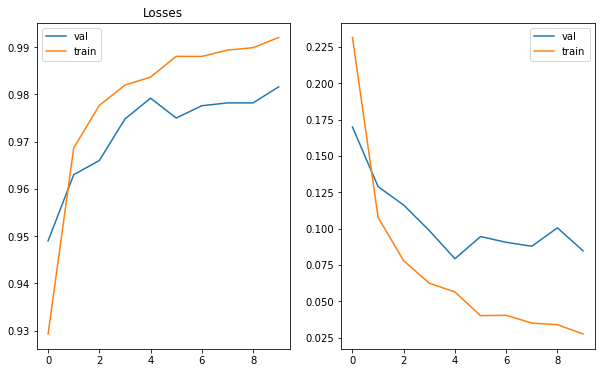

In [107]:
# Lets plot the val/ train accuracies and the losses of the network
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
# accuracies
axs[0].plot(mlp_accuracies['val'], label='val')
axs[0].plot(mlp_accuracies['train'], label='train')
axs[0].legend()
axs[0].set_title('Accuracies')
# losses
axs[1].plot(mlp_losses['val'], label='val')
axs[1].plot(mlp_losses['train'], label='train')
axs[1].legend()
axs[0].set_title('Losses')
# ----
plt.legend()
plt.plot()

### 4. Create a CNN

Now we create a CNN and compare it with the MLP.

In [129]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5)
        self.layer2 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5)
        self.layer3 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5)
        self.layer4 = nn.Conv2d(in_channels=10, out_channels=10, kernel_size=5)
        self.out_layer = nn.Linear(in_features=10, out_features=10)

    def forward(self, x):
        out = torch.relu(self.layer1(x)) # 24x24
        out = torch.relu(self.layer2(out)) # 12x12
        out = torch.relu(self.layer3(out)) # 8x8
        out = torch.relu(self.layer4(out)) # 4x4
        out = torch.mean(out, dim=(-2, -1))
        out = self.out_layer(out)
        return out

cnn = CNN()

In [130]:
# How big is the network?
print(f'The CNN has {num_params(cnn)} learnable parameters')

The CNN has 7900 learnable parameters


In [131]:
# Optimizer
lr = 0.001 # The learning rate of the optimizer
weight_decay = 1e-5 # Regularization on the size of the weights
optimizer = torch.optim.Adam( # Best optimizer out there. Named after Amsterdam.
    cnn.parameters(), 
    lr=lr,
    weight_decay=weight_decay,
)

# Optimization criterion: Cross entropy loss. The to-go loss for classifcation tasks.
# See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss() 

In [132]:
# Let's train the MLP for 10 epochs
# IMPORTANT!: Difficult tasks often require (much) more epochs.
no_epochs = 10
_, cnn_accuracies, cnn_losses = training_loop(
    epochs=no_epochs,
    model=cnn,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders={
        'train': train_dataloader,
        'val': val_dataloader,
    },
    device=device,
)

Epoch 1 / 10
train loss: 0.9000, accuracy: 0.6998
val loss: 0.3399, accuracy: 0.8938
Time per epoch: 9.3651
Epoch 2 / 10
train loss: 0.2999, accuracy: 0.9099
val loss: 0.2514, accuracy: 0.9236
Time per epoch: 9.5027
Epoch 3 / 10
train loss: 0.2169, accuracy: 0.9353
val loss: 0.2090, accuracy: 0.9350
Time per epoch: 9.6445
Epoch 4 / 10
train loss: 0.1764, accuracy: 0.9470
val loss: 0.1509, accuracy: 0.9532
Time per epoch: 9.7046
Epoch 5 / 10
train loss: 0.1446, accuracy: 0.9560
val loss: 0.1462, accuracy: 0.9504
Time per epoch: 10.0499
Epoch 6 / 10
train loss: 0.1267, accuracy: 0.9618
val loss: 0.1189, accuracy: 0.9632
Time per epoch: 10.9045
Epoch 7 / 10
train loss: 0.1162, accuracy: 0.9646
val loss: 0.1060, accuracy: 0.9670
Time per epoch: 11.1909
Epoch 8 / 10
train loss: 0.1036, accuracy: 0.9685
val loss: 0.1087, accuracy: 0.9686
Time per epoch: 12.8354
Epoch 9 / 10
train loss: 0.0962, accuracy: 0.9719
val loss: 0.0861, accuracy: 0.9732
Time per epoch: 12.9969
Epoch 10 / 10
train los

In [134]:
test_loop(
    model=cnn,
    test_dataloader=test_dataloader,
    device=device,
)

Accuracy of the network on the 10000 test samples: 97.73


[]

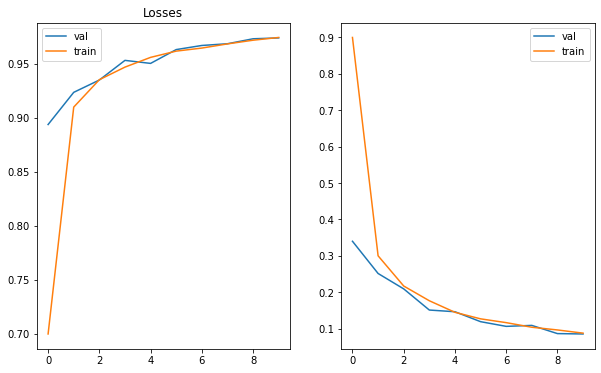

In [135]:
# Lets plot the val/ train accuracies and the losses of the network
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
# accuracies
axs[0].plot(cnn_accuracies['val'], label='val')
axs[0].plot(cnn_accuracies['train'], label='train')
axs[0].legend()
axs[0].set_title('Accuracies')
# losses
axs[1].plot(cnn_losses['val'], label='val')
axs[1].plot(cnn_losses['train'], label='train')
axs[1].legend()
axs[0].set_title('Losses')
# ----
plt.legend()
plt.plot()

In [139]:
class BiggerCNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=20, kernel_size=5)
        self.layer2 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5)
        self.layer3 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5)
        self.layer4 = nn.Conv2d(in_channels=20, out_channels=20, kernel_size=5)
        self.out_layer = nn.Linear(in_features=20, out_features=10)

    def forward(self, x):
        out = torch.relu(self.layer1(x)) 
        out = torch.relu(self.layer2(out))
        out = torch.relu(self.layer3(out)) 
        out = torch.relu(self.layer4(out)) 
        out = torch.mean(out, dim=(-2, -1))
        out = self.out_layer(out)
        return out

bigger_cnn = BiggerCNN()

In [140]:
# How big is the network?
print(f'The CNN has {num_params(bigger_cnn)} learnable parameters')

The CNN has 30790 learnable parameters


In [141]:
# Optimizer
lr = 0.001 # The learning rate of the optimizer
weight_decay = 1e-5 # Regularization on the size of the weights
optimizer = torch.optim.Adam( # Best optimizer out there. Named after Amsterdam.
    bigger_cnn.parameters(), 
    lr=lr,
    weight_decay=weight_decay,
)

# Optimization criterion: Cross entropy loss. The to-go loss for classifcation tasks.
# See https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss() 

In [142]:
# Let's train the MLP for 10 epochs
# IMPORTANT!: Difficult tasks often require (much) more epochs.
no_epochs = 10
_, bigger_cnn_accuracies, bigger_cnn_losses = training_loop(
    epochs=no_epochs,
    model=bigger_cnn,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders={
        'train': train_dataloader,
        'val': val_dataloader,
    },
    device=device,
)

Epoch 1 / 10
train loss: 0.6106, accuracy: 0.7999
val loss: 0.2883, accuracy: 0.9174
Time per epoch: 11.4344
Epoch 2 / 10
train loss: 0.2141, accuracy: 0.9359
val loss: 0.1824, accuracy: 0.9452
Time per epoch: 12.1577
Epoch 3 / 10
train loss: 0.1449, accuracy: 0.9565
val loss: 0.1265, accuracy: 0.9636
Time per epoch: 12.1248
Epoch 4 / 10
train loss: 0.1145, accuracy: 0.9659
val loss: 0.1139, accuracy: 0.9670
Time per epoch: 11.9070
Epoch 5 / 10
train loss: 0.0961, accuracy: 0.9703
val loss: 0.1062, accuracy: 0.9646
Time per epoch: 12.5818
Epoch 6 / 10
train loss: 0.0837, accuracy: 0.9746
val loss: 0.1084, accuracy: 0.9658
Time per epoch: 12.1196
Epoch 7 / 10
train loss: 0.0732, accuracy: 0.9782
val loss: 0.0767, accuracy: 0.9768
Time per epoch: 12.3307
Epoch 8 / 10
train loss: 0.0652, accuracy: 0.9803
val loss: 0.0771, accuracy: 0.9750
Time per epoch: 12.7509
Epoch 9 / 10
train loss: 0.0598, accuracy: 0.9819
val loss: 0.0653, accuracy: 0.9820
Time per epoch: 12.6199
Epoch 10 / 10
train

In [144]:
test_loop(
    model=bigger_cnn,
    test_dataloader=test_dataloader,
    device=device,
)

Accuracy of the network on the 10000 test samples: 98.52


[]

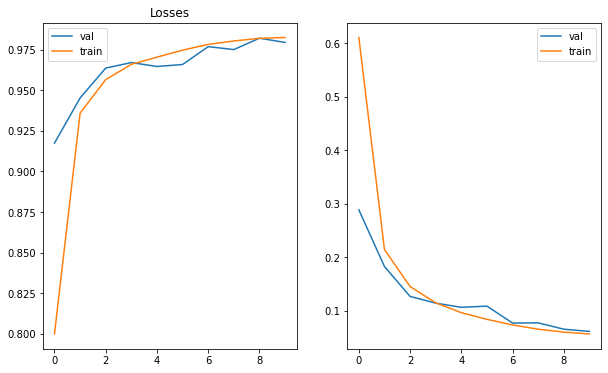

In [145]:
# Lets plot the val/ train accuracies and the losses of the network
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
# accuracies
axs[0].plot(bigger_cnn_accuracies['val'], label='val')
axs[0].plot(bigger_cnn_accuracies['train'], label='train')
axs[0].legend()
axs[0].set_title('Accuracies')
# losses
axs[1].plot(bigger_cnn_losses['val'], label='val')
axs[1].plot(bigger_cnn_losses['train'], label='train')
axs[1].legend()
axs[0].set_title('Losses')
# ----
plt.legend()
plt.plot()

In [146]:
# Let's train the MLP for 10 epochs
# IMPORTANT!: Difficult tasks often require (much) more epochs.
no_epochs = 50
_, bigger_cnn_accuracies, bigger_cnn_losses = training_loop(
    epochs=no_epochs,
    model=bigger_cnn,
    criterion=criterion,
    optimizer=optimizer,
    dataloaders={
        'train': train_dataloader,
        'val': val_dataloader,
    },
    device=device,
)

Epoch 1 / 50
train loss: 0.0529, accuracy: 0.9841
val loss: 0.0565, accuracy: 0.9822
Time per epoch: 11.4779
Epoch 2 / 50
train loss: 0.0505, accuracy: 0.9841
val loss: 0.0709, accuracy: 0.9784
Time per epoch: 12.2209
Epoch 3 / 50
train loss: 0.0475, accuracy: 0.9856
val loss: 0.0600, accuracy: 0.9830
Time per epoch: 11.7737
Epoch 4 / 50
train loss: 0.0430, accuracy: 0.9861
val loss: 0.0515, accuracy: 0.9840
Time per epoch: 11.6817
Epoch 5 / 50
train loss: 0.0410, accuracy: 0.9875
val loss: 0.0454, accuracy: 0.9866
Time per epoch: 12.0997
Epoch 6 / 50
train loss: 0.0381, accuracy: 0.9879
val loss: 0.0450, accuracy: 0.9868
Time per epoch: 11.8746
Epoch 7 / 50
train loss: 0.0365, accuracy: 0.9888
val loss: 0.0440, accuracy: 0.9866
Time per epoch: 11.4278
Epoch 8 / 50
train loss: 0.0338, accuracy: 0.9894
val loss: 0.0698, accuracy: 0.9780
Time per epoch: 10.7885
Epoch 9 / 50
train loss: 0.0343, accuracy: 0.9893
val loss: 0.0406, accuracy: 0.9880
Time per epoch: 10.8826
Epoch 10 / 50
train

In [147]:
test_loop(
    model=bigger_cnn,
    test_dataloader=test_dataloader,
    device=device,
)

Accuracy of the network on the 10000 test samples: 99.00


[]

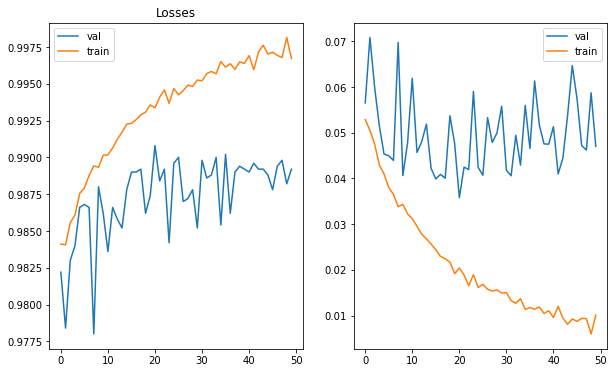

In [148]:
# Lets plot the val/ train accuracies and the losses of the network
fig, axs = plt.subplots(1, 2, figsize=(10, 6))
# accuracies
axs[0].plot(bigger_cnn_accuracies['val'], label='val')
axs[0].plot(bigger_cnn_accuracies['train'], label='train')
axs[0].legend()
axs[0].set_title('Accuracies')
# losses
axs[1].plot(bigger_cnn_losses['val'], label='val')
axs[1].plot(bigger_cnn_losses['train'], label='train')
axs[1].legend()
axs[0].set_title('Losses')
# ----
plt.legend()
plt.plot()